In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import os
os.chdir("..")

import random
from tqdm import tqdm
from pathlib import Path
import numpy as np
import cv2
from joblib import Parallel, delayed, parallel_backend
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, f1_score, precision_score, cohen_kappa_score
from multiprocessing.dummy import Pool
import pandas as pd

from skin_lesion_cad.data.BOVW import DenseDescriptor, BagofWords, ColorDescriptor,LBPDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesDescriptor
from skin_lesion_cad.features.colour import ColorFeaturesExtractor
from skin_lesion_cad.features.texture import glcm_features
from skin_lesion_cad.features.texture import get_glcm

import matplotlib.pyplot as plt
import seaborn as sns

from typing import Counter
from sklearn.base import TransformerMixin, BaseEstimator


import scipy

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
class ColorTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.scaler = StandardScaler()
    def fit(self, X, y=None):
        X[np.isnan(X)] = 0
        X[np.isinf(X)] = 0
        return self.scaler.fit(X)
    def transform(self, X, y=None):
        X[np.isnan(X)] = 0
        X[np.isinf(X)] = 0
        return self.scaler.transform(X)
    
    def fit_transform(self, X, y=None, **fit_params):
        self.fit(X)
        return self.transform(X, y)

In [8]:
SAMPLE_SIZE = 500
KP_SIZE = 25
color_spaces = {'bgr':cv2.COLOR_RGB2BGR, 'hsv':cv2.COLOR_RGB2HSV, 'YCrCb':cv2.COLOR_RGB2YCrCb}

root_path = Path().resolve()

chall1 = root_path/"data/processed/chall2/val"

mel_imgs_all = np.array(list((chall1/'mel').glob("*inpaint_0_5.png")))
bcc_imgs_all = np.array(list((chall1/'bcc').glob("*inpaint_0_5.png")))
scc_imgs_all = np.array(list((chall1/'scc').glob("*inpaint_0_5.png")))



test_imgs = np.concatenate([mel_imgs_all, bcc_imgs_all, scc_imgs_all])
brisk = cv2.BRISK_create(thresh=30, octaves=0)

# # use random sampling
# dense_desc = DenseDescriptor(descriptor=brisk, min_keypoints=100,
#                              max_keypoints=1000, kp_size=KP_SIZE,
#                              sample_method='random')


# dense_color = ColorDescriptor(dense_desc, color_spaces, meanshift=None,
#                               min_keypoints=100, max_keypoints=500,
#                               kp_size=25,
#                               sample_method='random')

# dense_texture = LBPDescriptor(descriptor=dense_desc,
#                                 min_keypoints=100, max_keypoints=500, 
#                                 kp_size=KP_SIZE,
#                                 sample_method='random')


# use gaussian sampling
dense_desc = DenseDescriptor(descriptor=None, min_keypoints=100,
                             max_keypoints=500, kp_size=KP_SIZE,
                             sample_method='gaussian')


dense_color = ColorDescriptor(dense_desc, color_spaces, meanshift=None,
                              min_keypoints=100, max_keypoints=500,
                              kp_size=25,
                              sample_method='gaussian')

dense_texture = LBPDescriptor(descriptor=dense_desc,
                                min_keypoints=100, max_keypoints=500, 
                                kp_size=KP_SIZE,
                                sample_method='gaussian')


# 0. Baseline: separate BoW models for color and texture

In [4]:
# def _load_and_extract_des_color_texture(x):
#     image_path, descriptor = x
#     im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
#     # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
#     if 'bcc' in str(image_path):
#         img_cls = 0
#     elif 'mel' in str(image_path):
#         img_cls = 1
#     else:
#         img_cls = 2

#     kpts, des = descriptor.detectAndCompute(im, None)
#     return (des, img_cls, image_path.name)


# descriptors_texture = []
# img_classes_texture = []
# img_names_texture = []
# # TEXTURE
# with Pool(8) as pool:
#     for (des, img_cls, img_name) in tqdm(pool.imap(_load_and_extract_des_color_texture,
#                                        zip(test_imgs,
#                                            [dense_texture]*len(test_imgs))), total=len(test_imgs)):
#         descriptors_texture.append(des)
#         img_classes_texture.append(img_cls)
#         img_names_texture.append(img_name)

In [4]:
# pd.to_pickle((descriptors_texture, img_classes_texture, img_names_texture), 'descriptors_texture_all_train.pkl')
descriptors_texture, img_classes_texture, img_names_texture  = pd.read_pickle('descriptors_texture_all_train.pkl')

In [9]:
def _load_and_extract_des_color(x):
    image_path, descriptor = x
    im = cv2.imread(str(image_path))
    # mask = cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    kpts, des = descriptor.detectAndCompute(im, None)
    return (des, img_cls, image_path.name)

descriptors_color = []
img_classes_color = []
img_names_color = []
# COLOR
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(_load_and_extract_des_color,
                                       zip(test_imgs,
                                           [dense_color]*len(test_imgs))), total=len(test_imgs)):
        descriptors_color.append(des)
        img_classes_color.append(img_cls)
        img_names_color.append(img_name)

100%|██████████| 1270/1270 [51:19<00:00,  2.42s/it] 


In [11]:
pd.to_pickle((descriptors_color, img_classes_color, img_names_color), 'descriptors_color_all_val_300keyp.pkl')
# descriptors_color, img_classes_color, img_names_color = pd.read_pickle('descriptors_color_all_train.pkl')

In [7]:
bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)

kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_texture = np.asarray(descriptors_texture)
img_classes_texture = np.asarray(img_classes_texture)
for train_index, test_index in tqdm(kf.split(descriptors_texture,
                                             img_classes_color), total=kf.get_n_splits()):
    X_train, X_test = descriptors_texture[train_index], descriptors_texture[test_index]
    y_train, y_test = img_classes_texture[train_index], img_classes_texture[test_index]
    
    X_train_preprocessed = bow_texture.fit_transform(X_train,y_train) 
    X_test_preprocessed = bow_texture.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='weighted'))

100%|██████████| 5/5 [04:45<00:00, 57.03s/it]


train_f1 0.7725062839356076  +- 0.004222327789872599
test_f1 0.7163989944393608  +- 0.022232597372904714
train_kappa 0.5004195751162619  +- 0.009082588826296149
test_kappa 0.3944780104972337  +- 0.04382415324837854


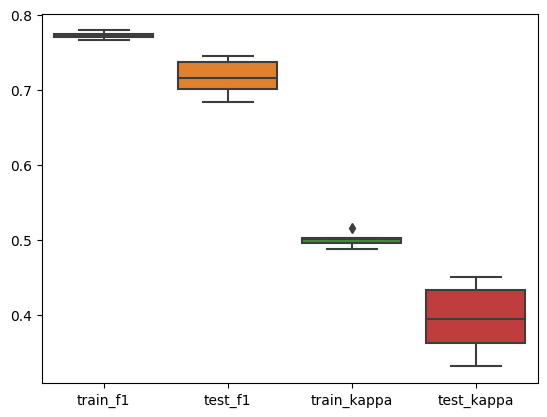

In [8]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

Random with brisk
```
train_f1 0.7799445657408125  +- 0.004393653741850997
test_f1 0.5073229550282539  +- 0.03189507346769425
train_kappa 0.6701373400986126  +- 0.006298608775474304
test_kappa 0.26761719945725104  +- 0.045155543376638595
```

In [9]:
bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)

kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_color = np.asarray(descriptors_color)
img_classes_color = np.asarray(img_classes_color)
for train_index, test_index in tqdm(kf.split(descriptors_color,
                                             img_classes_color), total=kf.get_n_splits()):
    X_train, X_test = descriptors_color[train_index], descriptors_color[test_index]
    y_train, y_test = img_classes_color[train_index], img_classes_color[test_index]
    
    X_train_preprocessed = bow_color.fit_transform(X_train,y_train) 
    X_test_preprocessed = bow_color.transform(X_test)
    
    classifier = SVC(C=1., kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='weighted'))

100%|██████████| 5/5 [05:09<00:00, 61.90s/it]


train_f1 0.8288166357984934  +- 0.0037811969732766963
test_f1 0.7856968100546247  +- 0.012988033788779947
train_kappa 0.634594291870972  +- 0.006928808692865047
test_kappa 0.5507567120032293  +- 0.023828494250565144


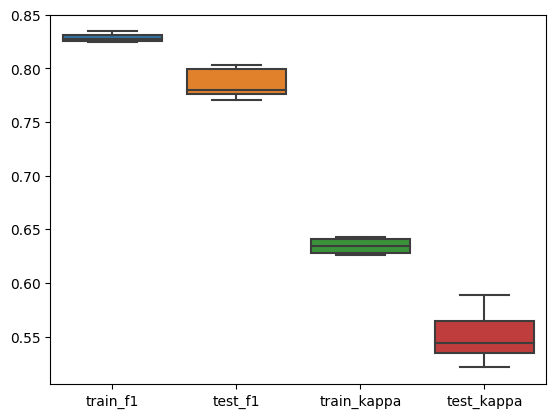

In [10]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

Random with color

```
train_f1 0.7666328568617333  +- 0.009875030921222225
test_f1 0.571777201448451  +- 0.023836374750108295
train_kappa 0.6499578398844867  +- 0.0156121466260396
test_kappa 0.3581376746541377  +- 0.03444177292288387
```

# 1. Fusing BoW vectors

In [11]:
color_df = pd.DataFrame({'img_name':img_names_color, 'img_class':img_classes_color}).reset_index().set_index('img_name')
texture_df = pd.DataFrame({'img_name':img_names_texture, 'img_class':img_classes_texture}).reset_index().set_index('img_name')
merged_df = color_df.join(texture_df, how='inner', lsuffix='_color', rsuffix='_texture')
merged_df

,index_color,img_class_color,index_texture,img_class_texture
img_name,,,,
mel02171_inpaint_0_5.png,0,1,0,1
mel01400_inpaint_0_5.png,1,1,1,1
mel00176_inpaint_0_5.png,2,1,2,1
mel02216_inpaint_0_5.png,3,1,3,1
mel00728_inpaint_0_5.png,4,1,4,1
...,...,...,...,...
scc00027_inpaint_0_5.png,5077,2,5077,2
scc00376_inpaint_0_5.png,5078,2,5078,2
scc00239_inpaint_0_5.png,5079,2,5079,2


With tf-idf as BoW vectors

In [12]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_color = np.asarray(descriptors_color)
img_classes_color = np.asarray(img_classes_color)

for train_index, test_index in tqdm(kf.split(merged_df,
                                             img_classes_color), total=kf.get_n_splits()):
    
    # color bow
    bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_color = merged_df.iloc[train_index].index_color
    test_index_color = merged_df.iloc[test_index].index_color
    X_train_color, X_test_color = descriptors_color[train_index_color], descriptors_color[test_index_color]
    y_train_color, y_test_color = img_classes_color[train_index_color], img_classes_color[test_index_color]
    
    X_train_preprocessed_color = bow_color.fit_transform(X_train_color,y_train_color) 
    X_test_preprocessed_color = bow_color.transform(X_test_color)
    
    # texture bow
    bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_texture = merged_df.iloc[train_index].index_texture
    test_index_texture = merged_df.iloc[test_index].index_texture
    X_train_texture, X_test_texture = descriptors_texture[train_index_texture], descriptors_texture[test_index_texture]
    y_train_texture, y_test_texture = img_classes_texture[train_index_texture], img_classes_texture[test_index_texture]
    
    X_train_preprocessed_texture = bow_texture.fit_transform(X_train_texture,y_train_texture) 
    X_test_preprocessed_texture = bow_texture.transform(X_test_texture)
    
    X_train_merged = scipy.sparse.hstack((X_train_preprocessed_color, X_train_preprocessed_texture))
    X_test_merged = scipy.sparse.hstack((X_test_preprocessed_color, X_test_preprocessed_texture))
    y_merged_train = y_train_color
    y_merged_test = y_test_color
    
    classifier = SVC(C=0.5, kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_merged, y_merged_train)
    y_pred = classifier.predict(X_test_merged)
    y_pred_train  = classifier.predict(X_train_merged)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_merged_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_merged_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_merged_test))
    scores['test_f1'].append(f1_score(y_pred, y_merged_test, average='weighted'))

100%|██████████| 5/5 [10:22<00:00, 124.58s/it]


train_f1 0.8455770410007363  +- 0.0022395397717071483
test_f1 0.7938379075247461  +- 0.006302099950838245
train_kappa 0.6517769457432341  +- 0.004284850071396546
test_kappa 0.5572868438604782  +- 0.010060330058704554


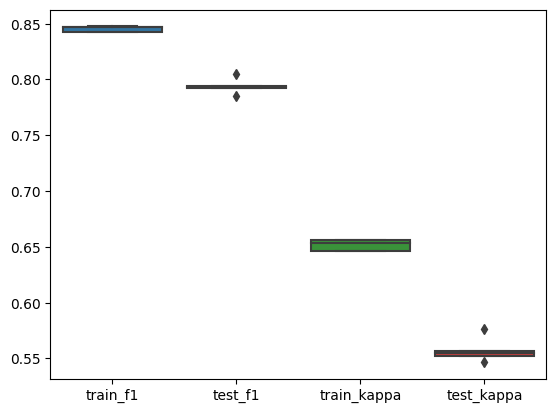

In [13]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

Without tf-idf and with simple term frequency
```

In [14]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
descriptors_color = np.asarray(descriptors_color)
img_classes_color = np.asarray(img_classes_color)

for train_index, test_index in tqdm(kf.split(merged_df,
                                             img_classes_color), total=kf.get_n_splits()):
    
    # color bow
    bow_color = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_color = merged_df.iloc[train_index].index_color
    test_index_color = merged_df.iloc[test_index].index_color
    X_train_color, X_test_color = descriptors_color[train_index_color], descriptors_color[test_index_color]
    y_train_color, y_test_color = img_classes_color[train_index_color], img_classes_color[test_index_color]
    
    X_train_preprocessed_color = bow_color.fit_transform(X_train_color,y_train_color, get_tfidf=False) 
    X_test_preprocessed_color = bow_color.transform(X_test_color, get_tfidf=False)
    
    # texture bow
    bow_texture = BagofWords(n_words=100, n_jobs=-1, random_state=None)
    train_index_texture = merged_df.iloc[train_index].index_texture
    test_index_texture = merged_df.iloc[test_index].index_texture
    X_train_texture, X_test_texture = descriptors_texture[train_index_texture], descriptors_texture[test_index_texture]
    y_train_texture, y_test_texture = img_classes_texture[train_index_texture], img_classes_texture[test_index_texture]
    
    X_train_preprocessed_texture = bow_texture.fit_transform(X_train_texture,y_train_texture, get_tfidf=False) 
    X_test_preprocessed_texture = bow_texture.transform(X_test_texture, get_tfidf=False)
    
    X_train_merged = np.hstack((X_train_preprocessed_color, X_train_preprocessed_texture))
    X_test_merged = np.hstack((X_test_preprocessed_color, X_test_preprocessed_texture))
    y_merged_train = y_train_color
    y_merged_test = y_test_color
    
    classifier = SVC(C=0.5, kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_merged, y_merged_train)
    y_pred = classifier.predict(X_test_merged)
    y_pred_train  = classifier.predict(X_train_merged)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_merged_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_merged_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_merged_test))
    scores['test_f1'].append(f1_score(y_pred, y_merged_test, average='weighted'))

100%|██████████| 5/5 [09:38<00:00, 115.78s/it]


train_f1 0.8241409257806918  +- 0.0022378536004590876
test_f1 0.7934365738782748  +- 0.003617568670382157
train_kappa 0.6147725350057518  +- 0.004031392978437388
test_kappa 0.5573548617320275  +- 0.006085819322518767


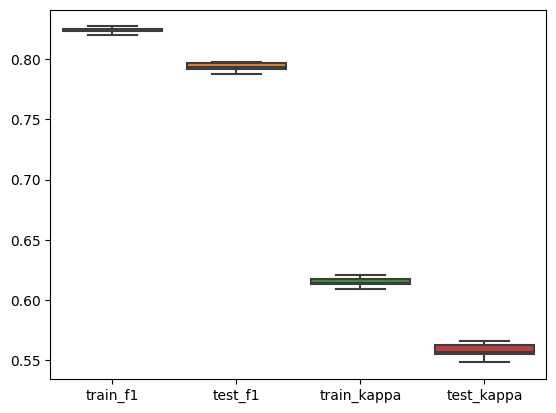

In [15]:
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

# 2. Global features: Color+Texture

#### Color

In [16]:
def extract_color(image_path):
    cfe = ColorFeaturesExtractor(color_spaces)
    im = cv2.imread(str(image_path))
    mask = np.ones_like(im[:,:,0]) #cv2.imread(str(image_path).replace('inpaint', 'mask'))
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = cfe.extract_masked(im, mask)

    return (des, img_cls, image_path.name)

colf = []
colcl = []
colnam = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_color,
                                       test_imgs), total=len(test_imgs)):
        colf.append(des)
        colcl.append(img_cls)
        colnam.append(img_name)

100%|██████████| 5082/5082 [04:44<00:00, 17.86it/s]


In [17]:
glob_col = pd.DataFrame(colf)
glob_col['img_cls'] = colcl
glob_col['img_name'] = colnam
glob_col = glob_col.set_index('img_name')
glob_col

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,YCrCb_C_unq,YCrCb_r_mean,YCrCb_r_std,YCrCb_r_skew,YCrCb_r_kurt,YCrCb_r_max,YCrCb_r_min,YCrCb_r_entrp,YCrCb_r_unq,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel02171_inpaint_0_5.png,177.279617,32.743603,-1.850649,4.170814,225.0,10.0,11.099614,215,141.429520,40.466473,...,6227,18.046026,8.666623,0.861154,-0.161449,51.219395,0.993500,11.011109,5856,1
mel01400_inpaint_0_5.png,102.760895,96.397743,0.100366,-1.750800,236.0,0.0,11.900070,237,85.253494,87.131348,...,7359,11.860671,13.495653,1.067140,-0.063559,50.750710,-0.336976,-inf,7041,1
mel00176_inpaint_0_5.png,183.095871,40.106400,-3.250729,10.717134,216.0,0.0,12.438648,217,165.935883,40.378418,...,2846,10.835106,7.586371,0.660497,-0.538148,33.223843,-8.176010,-inf,2846,1
mel02216_inpaint_0_5.png,187.707901,14.635185,-1.455783,1.575167,211.0,100.0,12.473477,104,175.329239,29.500044,...,3821,8.431945,9.739118,0.896123,-0.401378,35.890999,-6.508270,-inf,3816,1
mel00728_inpaint_0_5.png,219.576828,36.052063,-1.797824,2.371162,254.0,34.0,11.104611,200,185.464493,57.501469,...,5539,17.774185,13.257942,1.326323,0.303105,58.696339,-33.922615,-inf,5085,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00027_inpaint_0_5.png,63.764179,93.247322,0.862645,-1.190867,229.0,0.0,11.378574,230,55.859375,82.166565,...,5910,4.772316,8.136784,2.407248,6.096476,51.844303,-1.330180,-inf,5908,2
scc00376_inpaint_0_5.png,191.878189,23.707539,-2.076357,6.261881,250.0,16.0,11.111322,214,141.407166,34.657181,...,4744,24.693176,6.781693,1.096197,0.757938,52.619244,-7.419688,-inf,4325,2
scc00239_inpaint_0_5.png,223.139496,26.602098,-1.537225,2.481799,255.0,87.0,11.112221,169,174.483795,36.883003,...,4167,26.006914,7.858440,0.600797,-0.585916,47.390400,8.951541,11.075516,4041,2


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

train_f1 0.8444037725517572  +- 0.0010614893895972654
test_f1 0.8252739237670929  +- 0.0066599358072546135
train_kappa 0.6475894363867412  +- 0.0020068630403735346
test_kappa 0.6130110249830638  +- 0.011565111524562247


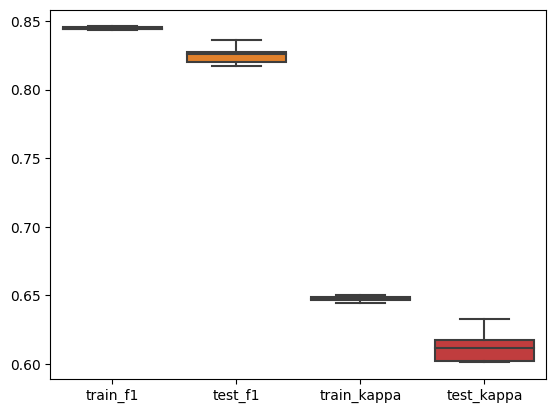

In [18]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
for train_index, test_index in tqdm(kf.split(glob_col, glob_col.img_cls.values), total=kf.get_n_splits()):
    X_train = glob_col.drop(columns=['img_cls']).iloc[train_index].values
    X_test = glob_col.drop(columns=['img_cls']).iloc[test_index].values
    y_train = glob_col.iloc[train_index].img_cls.values
    y_test = glob_col.iloc[test_index].img_cls.values
    
    prep = ColorTransformer()
    X_train_preprocessed = prep.fit_transform(X_train,y_train) 
    X_test_preprocessed = prep.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='weighted'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

#### Texture

In [19]:
def extract_text(image_path):
    im = cv2.imread(str(image_path), cv2.IMREAD_GRAYSCALE)
    if 'bcc' in str(image_path):
        img_cls = 0
    elif 'mel' in str(image_path):
        img_cls = 1
    else:
        img_cls = 2

    des = glcm_features(im)

    return (des, img_cls, image_path.name)

txtf = []
txtcl = []
txtnam = []
with Pool(8) as pool:
    for (des, img_cls, img_name) in tqdm(pool.imap(extract_text,
                                       test_imgs), total=len(test_imgs)):
        txtf.append(des)
        txtcl.append(img_cls)
        txtnam.append(img_name)

100%|██████████| 5082/5082 [01:41<00:00, 50.19it/s]


In [20]:
txtf_exp = []
for i in range(len(txtf)):
    res = dict()
    for feat in txtf[i].keys():
        for featvalidx, featval in enumerate(txtf[i][feat][0]):
            res[f'{feat}_{featvalidx}'] = featval
    txtf_exp.append(res)

glob_txt = pd.DataFrame(txtf_exp)
glob_txt['img_cls'] = txtcl
glob_txt['img_name'] = txtnam
glob_txt = glob_txt.set_index('img_name')
glob_txt

,contrast_0,contrast_1,contrast_2,contrast_3,contrast_4,contrast_5,contrast_6,contrast_7,dissimilarity_0,dissimilarity_1,...,correlation_7,ASM_0,ASM_1,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel02171_inpaint_0_5.png,37.024355,25.972513,43.313558,26.060410,118.161507,156.938394,135.077561,146.720879,4.042521,3.311559,...,0.950283,0.000737,0.000879,0.000674,0.000843,0.000431,0.000391,0.000403,0.000384,1
mel01400_inpaint_0_5.png,39.624743,25.582948,43.126007,24.981051,156.690424,199.892093,166.556814,198.263613,3.339105,2.689730,...,0.987167,0.025313,0.025478,0.025472,0.025500,0.022850,0.021951,0.023185,0.022034,1
mel00176_inpaint_0_5.png,9.573169,5.522761,8.325065,5.094060,38.135228,45.484275,35.530526,43.847092,2.195090,1.627732,...,0.985317,0.002597,0.003159,0.002872,0.003306,0.001596,0.001542,0.001752,0.001631,1
mel02216_inpaint_0_5.png,7.913362,4.657573,4.966261,4.397605,17.275668,18.531984,12.801671,17.120253,1.550793,1.294503,...,0.987666,0.004849,0.005309,0.004874,0.005550,0.003647,0.003486,0.003671,0.003725,1
mel00728_inpaint_0_5.png,61.821193,57.422778,83.971465,27.830506,135.542539,195.146065,211.042939,190.022869,3.451201,3.099946,...,0.965419,0.001712,0.001844,0.001481,0.001927,0.001102,0.000915,0.000938,0.000982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00027_inpaint_0_5.png,17.305599,9.375956,18.256648,9.750893,95.621306,120.252724,98.537587,125.108008,1.586259,1.232168,...,0.991383,0.114464,0.114158,0.113954,0.114672,0.109927,0.107968,0.110413,0.107786,2
scc00376_inpaint_0_5.png,110.249873,76.169643,106.220314,67.206358,276.378154,329.689113,261.978182,291.673964,6.277852,5.355441,...,0.852335,0.000619,0.000697,0.000554,0.000735,0.000374,0.000335,0.000354,0.000347,2
scc00239_inpaint_0_5.png,71.730708,50.245536,67.282750,45.176601,176.607638,221.991149,181.311182,190.074508,6.128322,5.074489,...,0.922581,0.000500,0.000609,0.000528,0.000637,0.000327,0.000307,0.000337,0.000324,2


100%|██████████| 5/5 [00:01<00:00,  4.04it/s]

train_f1 0.7006079923447903  +- 0.004776491856471857
test_f1 0.6915357774281261  +- 0.019672654045460276
train_kappa 0.3700515628279855  +- 0.009729815494058644
test_kappa 0.35236961516713594  +- 0.033972148666574276


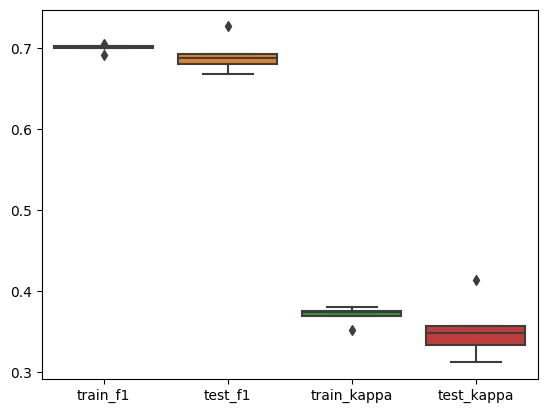

In [21]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
for train_index, test_index in tqdm(kf.split(glob_txt, glob_txt.img_cls.values), total=kf.get_n_splits()):
    X_train = glob_txt.drop(columns=['img_cls']).iloc[train_index].values
    X_test = glob_txt.drop(columns=['img_cls']).iloc[test_index].values
    y_train = glob_txt.iloc[train_index].img_cls.values
    y_test = glob_txt.iloc[test_index].img_cls.values
    
    prep = ColorTransformer()
    X_train_preprocessed = prep.fit_transform(X_train,y_train) 
    X_test_preprocessed = prep.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='weighted'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

#### Color+Texture

In [22]:
merged_global_df = glob_col.drop(columns=['img_cls']).join(glob_txt, how='inner')
merged_global_df

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,correlation_7,ASM_0,ASM_1,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel02171_inpaint_0_5.png,177.279617,32.743603,-1.850649,4.170814,225.0,10.0,11.099614,215,141.429520,40.466473,...,0.950283,0.000737,0.000879,0.000674,0.000843,0.000431,0.000391,0.000403,0.000384,1
mel01400_inpaint_0_5.png,102.760895,96.397743,0.100366,-1.750800,236.0,0.0,11.900070,237,85.253494,87.131348,...,0.987167,0.025313,0.025478,0.025472,0.025500,0.022850,0.021951,0.023185,0.022034,1
mel00176_inpaint_0_5.png,183.095871,40.106400,-3.250729,10.717134,216.0,0.0,12.438648,217,165.935883,40.378418,...,0.985317,0.002597,0.003159,0.002872,0.003306,0.001596,0.001542,0.001752,0.001631,1
mel02216_inpaint_0_5.png,187.707901,14.635185,-1.455783,1.575167,211.0,100.0,12.473477,104,175.329239,29.500044,...,0.987666,0.004849,0.005309,0.004874,0.005550,0.003647,0.003486,0.003671,0.003725,1
mel00728_inpaint_0_5.png,219.576828,36.052063,-1.797824,2.371162,254.0,34.0,11.104611,200,185.464493,57.501469,...,0.965419,0.001712,0.001844,0.001481,0.001927,0.001102,0.000915,0.000938,0.000982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00027_inpaint_0_5.png,63.764179,93.247322,0.862645,-1.190867,229.0,0.0,11.378574,230,55.859375,82.166565,...,0.991383,0.114464,0.114158,0.113954,0.114672,0.109927,0.107968,0.110413,0.107786,2
scc00376_inpaint_0_5.png,191.878189,23.707539,-2.076357,6.261881,250.0,16.0,11.111322,214,141.407166,34.657181,...,0.852335,0.000619,0.000697,0.000554,0.000735,0.000374,0.000335,0.000354,0.000347,2
scc00239_inpaint_0_5.png,223.139496,26.602098,-1.537225,2.481799,255.0,87.0,11.112221,169,174.483795,36.883003,...,0.922581,0.000500,0.000609,0.000528,0.000637,0.000327,0.000307,0.000337,0.000324,2


100%|██████████| 5/5 [00:01<00:00,  3.37it/s]

train_f1 0.8468661610126995  +- 0.003475917193935953
test_f1 0.8236629927470851  +- 0.006182690312992833
train_kappa 0.6522530975537548  +- 0.006146878975535189
test_kappa 0.6097991918051211  +- 0.009108688162040445


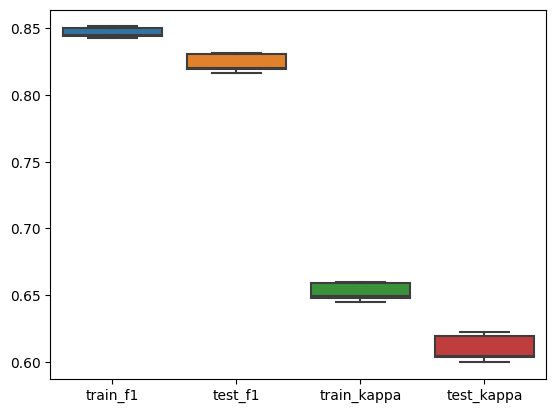

In [23]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}
for train_index, test_index in tqdm(kf.split(merged_global_df, merged_global_df.img_cls.values), total=kf.get_n_splits()):
    X_train = merged_global_df.drop(columns=['img_cls']).iloc[train_index].values
    X_test = merged_global_df.drop(columns=['img_cls']).iloc[test_index].values
    y_train = merged_global_df.iloc[train_index].img_cls.values
    y_test = merged_global_df.iloc[test_index].img_cls.values
    
    prep = ColorTransformer()
    X_train_preprocessed = prep.fit_transform(X_train,y_train) 
    X_test_preprocessed = prep.transform(X_test)
    
    classifier = SVC(C=0.5, kernel='rbf', random_state=42, class_weight='balanced')
    classifier.fit(X_train_preprocessed,y_train)
    y_pred = classifier.predict(X_test_preprocessed)
    y_pred_train  = classifier.predict(X_train_preprocessed)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_test))
    scores['test_f1'].append(f1_score(y_pred, y_test, average='weighted'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

# 3. Combine BoW with global color + texture

In [24]:
merged_df

,index_color,img_class_color,index_texture,img_class_texture
img_name,,,,
mel02171_inpaint_0_5.png,0,1,0,1
mel01400_inpaint_0_5.png,1,1,1,1
mel00176_inpaint_0_5.png,2,1,2,1
mel02216_inpaint_0_5.png,3,1,3,1
mel00728_inpaint_0_5.png,4,1,4,1
...,...,...,...,...
scc00027_inpaint_0_5.png,5077,2,5077,2
scc00376_inpaint_0_5.png,5078,2,5078,2
scc00239_inpaint_0_5.png,5079,2,5079,2


In [25]:
merged_global_df

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,correlation_7,ASM_0,ASM_1,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,img_cls
img_name,,,,,,,,,,,,,,,,,,,,,
mel02171_inpaint_0_5.png,177.279617,32.743603,-1.850649,4.170814,225.0,10.0,11.099614,215,141.429520,40.466473,...,0.950283,0.000737,0.000879,0.000674,0.000843,0.000431,0.000391,0.000403,0.000384,1
mel01400_inpaint_0_5.png,102.760895,96.397743,0.100366,-1.750800,236.0,0.0,11.900070,237,85.253494,87.131348,...,0.987167,0.025313,0.025478,0.025472,0.025500,0.022850,0.021951,0.023185,0.022034,1
mel00176_inpaint_0_5.png,183.095871,40.106400,-3.250729,10.717134,216.0,0.0,12.438648,217,165.935883,40.378418,...,0.985317,0.002597,0.003159,0.002872,0.003306,0.001596,0.001542,0.001752,0.001631,1
mel02216_inpaint_0_5.png,187.707901,14.635185,-1.455783,1.575167,211.0,100.0,12.473477,104,175.329239,29.500044,...,0.987666,0.004849,0.005309,0.004874,0.005550,0.003647,0.003486,0.003671,0.003725,1
mel00728_inpaint_0_5.png,219.576828,36.052063,-1.797824,2.371162,254.0,34.0,11.104611,200,185.464493,57.501469,...,0.965419,0.001712,0.001844,0.001481,0.001927,0.001102,0.000915,0.000938,0.000982,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00027_inpaint_0_5.png,63.764179,93.247322,0.862645,-1.190867,229.0,0.0,11.378574,230,55.859375,82.166565,...,0.991383,0.114464,0.114158,0.113954,0.114672,0.109927,0.107968,0.110413,0.107786,2
scc00376_inpaint_0_5.png,191.878189,23.707539,-2.076357,6.261881,250.0,16.0,11.111322,214,141.407166,34.657181,...,0.852335,0.000619,0.000697,0.000554,0.000735,0.000374,0.000335,0.000354,0.000347,2
scc00239_inpaint_0_5.png,223.139496,26.602098,-1.537225,2.481799,255.0,87.0,11.112221,169,174.483795,36.883003,...,0.922581,0.000500,0.000609,0.000528,0.000637,0.000327,0.000307,0.000337,0.000324,2


In [26]:
merged_df_global_bow = merged_global_df.drop(columns=['img_cls']).join(merged_df, how='inner')
merged_df_global_bow

,bgr_b_mean,bgr_b_std,bgr_b_skew,bgr_b_kurt,bgr_b_max,bgr_b_min,bgr_b_entrp,bgr_b_unq,bgr_g_mean,bgr_g_std,...,ASM_2,ASM_3,ASM_4,ASM_5,ASM_6,ASM_7,index_color,img_class_color,index_texture,img_class_texture
img_name,,,,,,,,,,,,,,,,,,,,,
mel02171_inpaint_0_5.png,177.279617,32.743603,-1.850649,4.170814,225.0,10.0,11.099614,215,141.429520,40.466473,...,0.000674,0.000843,0.000431,0.000391,0.000403,0.000384,0,1,0,1
mel01400_inpaint_0_5.png,102.760895,96.397743,0.100366,-1.750800,236.0,0.0,11.900070,237,85.253494,87.131348,...,0.025472,0.025500,0.022850,0.021951,0.023185,0.022034,1,1,1,1
mel00176_inpaint_0_5.png,183.095871,40.106400,-3.250729,10.717134,216.0,0.0,12.438648,217,165.935883,40.378418,...,0.002872,0.003306,0.001596,0.001542,0.001752,0.001631,2,1,2,1
mel02216_inpaint_0_5.png,187.707901,14.635185,-1.455783,1.575167,211.0,100.0,12.473477,104,175.329239,29.500044,...,0.004874,0.005550,0.003647,0.003486,0.003671,0.003725,3,1,3,1
mel00728_inpaint_0_5.png,219.576828,36.052063,-1.797824,2.371162,254.0,34.0,11.104611,200,185.464493,57.501469,...,0.001481,0.001927,0.001102,0.000915,0.000938,0.000982,4,1,4,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
scc00027_inpaint_0_5.png,63.764179,93.247322,0.862645,-1.190867,229.0,0.0,11.378574,230,55.859375,82.166565,...,0.113954,0.114672,0.109927,0.107968,0.110413,0.107786,5077,2,5077,2
scc00376_inpaint_0_5.png,191.878189,23.707539,-2.076357,6.261881,250.0,16.0,11.111322,214,141.407166,34.657181,...,0.000554,0.000735,0.000374,0.000335,0.000354,0.000347,5078,2,5078,2
scc00239_inpaint_0_5.png,223.139496,26.602098,-1.537225,2.481799,255.0,87.0,11.112221,169,174.483795,36.883003,...,0.000528,0.000637,0.000327,0.000307,0.000337,0.000324,5079,2,5079,2


100%|██████████| 5/5 [01:27<00:00, 17.50s/it]

train_f1 0.848246578834299  +- 0.002357135808168443
test_f1 0.8232242823722175  +- 0.008331447381653733
train_kappa 0.6552403179204095  +- 0.004185835213592153
test_kappa 0.6092349285114084  +- 0.014896520360102796


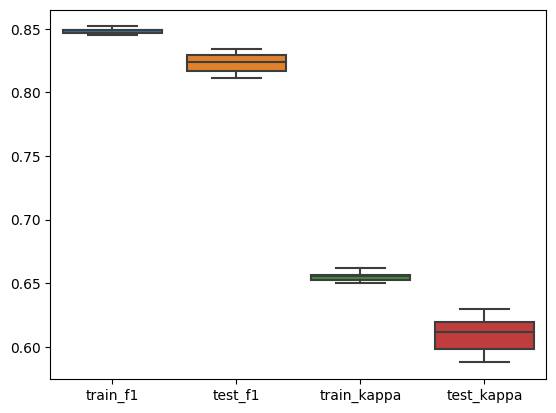

In [27]:
kf = StratifiedKFold(n_splits=5, shuffle=True)

scores = {'train_f1':[], 'test_f1':[], 'train_kappa':[], 'test_kappa':[]}


for train_index, test_index in tqdm(kf.split(merged_df_global_bow.drop(columns=['img_class_color',
                                                                                'img_class_texture']),
                                             merged_df_global_bow.img_class_texture.values),
                                    total=kf.get_n_splits()):
    
    # color bow
    bow_color = BagofWords(n_words=20, n_jobs=-1, random_state=None)
    train_index_color = merged_df_global_bow.iloc[train_index].index_color
    test_index_color = merged_df_global_bow.iloc[test_index].index_color
    X_train_color, X_test_color = descriptors_color[train_index_color], descriptors_color[test_index_color]
    y_train_color, y_test_color = img_classes_color[train_index_color], img_classes_color[test_index_color]
    
    X_train_preprocessed_color = bow_color.fit_transform(X_train_color,y_train_color) 
    X_test_preprocessed_color = bow_color.transform(X_test_color)
    
    train_global = merged_df_global_bow.iloc[train_index].drop(columns=['index_color',
                                                                        'img_class_color',
                                                                        'index_texture',
                                                                        'img_class_texture']).values
    test_global = merged_df_global_bow.iloc[test_index].drop(columns=['index_color',
                                                                        'img_class_color',
                                                                        'index_texture',
                                                                        'img_class_texture']).values
    scl = ColorTransformer()
    train_global = scl.fit_transform(train_global)
    test_global = scl.transform(test_global)
    
    X_train_merged = X_train_preprocessed_color
    X_train_merged = np.hstack([X_train_merged.toarray(), train_global])

    X_test_merged = X_test_preprocessed_color
    X_test_merged = np.hstack([X_test_merged.toarray(), test_global])

    
    y_merged_train = y_train_color
    y_merged_test = y_test_color
    
    classifier = SVC(C=0.5, kernel='rbf', class_weight='balanced')
    classifier.fit(X_train_merged, y_merged_train)
    y_pred = classifier.predict(X_test_merged)
    y_pred_train  = classifier.predict(X_train_merged)
    
    scores['train_kappa'].append(cohen_kappa_score(y_pred_train, y_merged_train))
    scores['train_f1'].append(f1_score(y_pred_train, y_merged_train, average='weighted'))
    scores['test_kappa'].append(cohen_kappa_score(y_pred, y_merged_test))
    scores['test_f1'].append(f1_score(y_pred, y_merged_test, average='weighted'))
    
sns.boxplot(data=pd.DataFrame(scores))
for k, v in scores.items():
    print(k, np.mean(v), ' +-', np.std(v))

# 4. Check how many words preferably 10, 20, 50, 100, 200, 500, 1000